<img src="AutoEncoder.png" width="300">

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# The neuron non-linearity

In [2]:
def ReLU(z):
    return np.maximum(0,z)
    
def ReLUPrime(z):
    return 1. if z > 0. else 0.

def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def sigmoidPrime(z):
    # Derivative of Sigmoid Function
    # dy/dz = e^-z / (1+e^-z)^2 = y * (1-y)
    return np.exp(-z) / ((1+np.exp(-z))**2)

# apply the function on every element of a vector
ReLU = np.vectorize(ReLU)
ReLUPrime = np.vectorize(ReLUPrime)
sigmoid = np.vectorize(sigmoid)
sigmoidPrime = np.vectorize(sigmoidPrime)

f = ReLU
fPrime = ReLUPrime

(-0.1, 1.5)

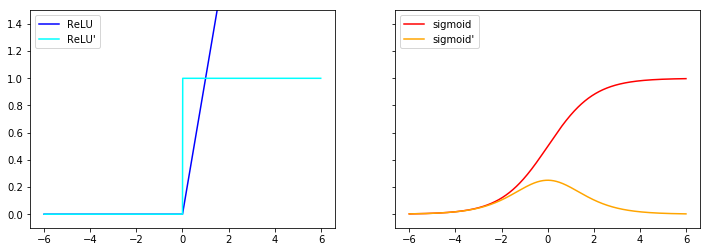

In [3]:
x = np.arange(-6, 6, 0.01)
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(12,4))
ax1.plot(x, ReLU(x), label="ReLU", color="blue")
ax1.plot(x, ReLUPrime(x), label="ReLU'", color="cyan")
ax1.legend(loc=2)

ax2.plot(x, sigmoid(x), label="sigmoid", color="red")
ax2.plot(x, sigmoidPrime(x), label="sigmoid'", color="orange")
ax2.legend(loc=2)

plt.ylim(-.1,1.5)

In [4]:
def sample():
    x = np.random.uniform(low=0.0, high=50.0)
    y = np.random.uniform(low=0.0, high=30.0)
    z_1 = 0.25 * x + 0.75 * y + np.random.normal(loc=0.0, scale=0.01)
    z_2 = .33333 * y + .66666 * x + np.random.normal(loc=0.0, scale=0.01)
    return np.array([x, z_1, y, z_2])

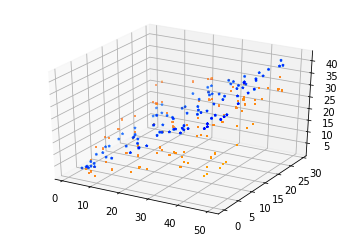

In [5]:
from mpl_toolkits.mplot3d import Axes3D
data = [ sample() for i in range(0,100) ]
xs = [ s[0] for s in data ]
ys = [ s[2] for s in data ]
zs1 = [0.25 * x + 0.75 * y for (x,y) in zip(xs,ys)]
zs1_ = [ s[1] for s in data ]
zs2 = [.33333 * y + .66666 * x for (x,y) in zip(xs,ys)]
zs2_ = [ s[3] for s in data ]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs=zs1, s=5, marker='+', color="red")
ax.scatter(xs, ys, zs=zs1_, s=5, marker='+', color="orange")
ax.scatter(xs, ys, zs=zs2, s=5, marker='*', color="blue")
ax.scatter(xs, ys, zs=zs2_, s=5, marker='*', color="cyan")

## Total Error

$error(target, output) = \frac{1}{2} \sum\limits_{i}{(target_i-output_i)^2}$

In [6]:
def error(target, output):
    return .5 * sum(map(lambda ty: (ty[0]-ty[1])**2, zip(target, output)))

## Layer containing neurons and weights from prev layer

<img src="AutoEncoder.png" width="300">

In [7]:
class Layer(object):
    def __init__(self, name, N_in, N, norm=True, weight_scale=0.01, with_bias=False):
        self.name = name
        self.N = N
        self.N_in = N_in
        
        # summed input
        self.Z = np.zeros(N)
        self.E_Z = np.zeros(N)
        
        # and applied non-linearity
        self.Y = np.zeros(N)
        self.E_Y = np.zeros(N)
        
        # add bias weights, if requested
        bias = 1 if with_bias else 0
        # initialize incomming weights
        if norm:
            self.W = np.random.normal(loc=0.0, scale=weight_scale, size=(N_in + bias, N))
        else:
            self.W = np.random.uniform(low=0.0, high=weight_scale, size=(N_in + bias, N))
        self.E_W = np.zeros(self.W.shape)
        # store last velocity
        self.V = np.zeros(self.W.shape)
        
    def reset_error(self):
        self.E_Y *= 0
        self.E_Z *= 0
        self.E_W *= 0
    
    def write(self):
        print("Name: ", self.name)
        print("Y   :\n", self.Y)
        print("E_Y :\n", self.E_Y)
        print("Z   :\n", self.Z)
        print("E_Z :\n", self.E_Z)
        print("W   :\n", self.W)
        print("E_W :\n", self.E_W)

    def plot(self):
        f, axes = plt.subplots(2, 1)
        (axW, axY) = axes
        axW.imshow(self.W,
                   cmap="gray",
                   interpolation='none',
                   vmax=np.max(self.W), vmin=np.min(self.W))
        axY.imshow([self.Y],
                   cmap="gray",
                   interpolation='none',
                   vmax=np.max(self.Y), vmin=np.min(self.Y))
        for a in axes:
            a.get_xaxis().set_visible(False)
            a.get_yaxis().set_visible(False)

## Batch Learn

In [8]:
def batch(layers, targets, eps, momentum, with_bias=False):
    """
    Do one batch learning step.

    layers:     np.array with multiple layers
    targets:    np.array with multiple training causes
    eps:        double   learning rate
    momentum:   double   momentum rate (0..1)
    with_bias:  boolean  if true add 'bias neuron'
    """
    # accumulate the average error
    err = 0.0
    for target in targets:
        # for each target do forward step
        output = forward( layers, target, with_bias )
        # and estimate gradient
        backward( layers, target, with_bias )
        # sum errors
        err += error(target, output)
    
    batch_size = len(targets)
    if not with_bias:
        # Both weight matrixes should have the same values
        # for auto encoders, so sum the matrices
        E_W = layers[0].E_W + np.transpose(layers[1].E_W)
        # and set the sum
        layers[0].E_W = E_W
        layers[1].E_W = np.transpose(E_W)
        # and then you have 'twice' the number of training sets
        batch_size *= 2.0
    
    # do one learn step with the summed gradients
    learn(layers, eps, batch_size, momentum)
    
    for l in layers:
        l.reset_error()

    return err / len(targets)

## Forward Path

In [9]:
def forward(layers, training, with_bias=False):
    """
    layers:    np.array with multiple layers
    training:  np.array with one training case
    with_bias: boolean  if true add 'bias neuron'
    """
    I = training
    if with_bias:
        I = np.append(I, [1.0])
    for l in layers:
        l.Z = I.dot(l.W)
        l.Y = f(l.Z)
        I = l.Y
        if with_bias:
            I = np.append(I, [1.0])
    
    return I[0:len(layers[-1].Y)]

## Backward Path and Error Computing

$error(target, output) = \frac{1}{2} \sum\limits_{i}{(target_i-output_i)^2}$

<img src="Backpropagation.png" width="400">
Source: LeCun et al (2015), Deep learning, NATURE, doi:10.1038/nature14539

In [10]:
def backward(layers, training, with_bias=False):
    """
    layers:    np.array with multiple layers
    training:  np.array with one training case
    with_bias: boolean  if true add 'bias neuron'
    """
    output = layers[1]
    hidden = layers[0]
    # Output layer
    # dE/dY_O = (-(target - output)) = output - target
    output.E_Y = output.Y - training
    # dE/dZ_O = dE/dY_O * dY_O/dZ_O
    output.E_Z = output.E_Y * fPrime(output.Z)
    # dE/dW2 = Y_H * dE/dZ_O
    # mini-batch
    Y = hidden.Y
    if with_bias:
        Y = np.append(Y, [1.0])
    output.E_W += np.transpose([Y]) * [output.E_Z]
    
    # Hidden layer
    # dE/dY_H = dE/dZ_O * trans(W2)
    hidden.E_Y = output.E_Z.dot(np.transpose(output.W))
    # dE/dZ_H = dE/dY_H * dY_H/dZ_H
    hidden.E_Z = hidden.E_Y[0:len(hidden.Z)] * fPrime(hidden.Z)
    # dE/dW1 = Y_I * dE/dZ_H
    # mini-batch
    Y = training
    if with_bias:
        Y = np.append(Y, [1.0])
    hidden.E_W += np.transpose([Y]) * [hidden.E_Z]

## Momentum SGD Learning

In [11]:
def learn(layers, eps, batch_size, momentum):
    """
    layers:     np.array with multiple layers
    eps:        double   learning rate
    batch_size: integer  number of training cases in last batch
    momentum:   double   momentum rate (0..1)
    """
    for l in layers:
        # adjust old velocity    and go into the new gradient
        V_curr = momentum * l.V - eps * l.E_W / batch_size
        # apply new velocity
        l.W = l.W + V_curr
        # store for next learn
        l.V = V_curr

## Nesterov's Accelerated Gradient

Similar to momentum SGD, but first do the velocity/momentum step,
then measure the gradient at this point and correct the new error.

<img src="NAG.png">
Source: [G. Hinton's lecture 6c](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)

In [12]:
def NAG_batch(layers, targets, eps, momentum, with_bias=False):
    # first jump into prev. direction
    V_curr = []
    for l in layers:
        V_tmp = momentum * l.V
        l.W = l.W + V_tmp
        V_curr.append(V_tmp)

    # measure gradients
    err = 0.0
    for target in targets:
        output = forward( layers, target, with_bias )
        backward( layers, target, with_bias )
        err += error(target, output)
    
    # apply gradient
    batch_size = len(targets)
    if not with_bias:
        # Both weight matrixes should have the same values
        # for auto encoders, so sum the matrices
        E_W = layers[0].E_W + np.transpose(layers[1].E_W)
        # and set the sum
        layers[0].E_W = E_W
        layers[1].E_W = np.transpose(E_W)
        # and then you have 'twice' the number of training sets
        batch_size *= 2.0
    
    for l, v in zip(layers, V_curr):
        G_tmp = eps * l.E_W / batch_size
        l.W = l.W - G_tmp
        l.V = v - G_tmp
    
    for l in layers:
        l.reset_error()

    return err / len(targets)

# Create AutoEncoder

<img src="AutoEncoder.png" width="300">


In [13]:
scale = 0.01
norm = False
use_bias = False
h = Layer("hidden", 4, 2, norm, scale, use_bias)
o = Layer("output", 2, 4, norm, scale, use_bias)
layers = [h,o]

if not use_bias:
    h.W = np.transpose(o.W)

# Learning
learn_errors = []

## Train AutoEncoder

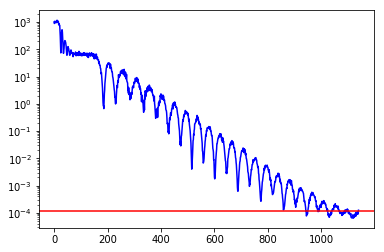

In [14]:
eps = 0.00001
momentum = 0.99

try:
    for i in range(0, 10000):
        if i % 19 == 0:
            plt.clf()
            plt.plot(range(0, len(learn_errors)),
                     learn_errors, color='blue')
            plt.yscale('log')
            if i > 100:
                plt.axhline(y=np.mean(learn_errors[-100:-1]), color="red")
            display.display(plt.gcf())
            display.clear_output(wait=True)

        targets = [ sample() for i in range(0,100) ]
        err = NAG_batch(layers, targets, eps=eps, momentum=momentum, with_bias=use_bias)
        #err = batch(layers, targets, eps=eps, momentum=momentum, with_bias=use_bias)

        learn_errors += [err]
        if np.mean(learn_errors[-100:-1]) < 1.e-4:
            break
except KeyboardInterrupt:
    print("Interrupted")

## Print

In [15]:
t = sample()
o = forward(layers, t, use_bias)
for l in reversed(layers):
    l.reset_error()
    l.write()
    print()
print("Input :", t)
print("Output:", o)
print("Diff  :", o - t)
print("Error :", error(t, o))

Name:  output
Y   :
 [ 35.21782832  20.01413589  14.94480233  28.4616877 ]
E_Y :
 [ 0. -0.  0. -0.]
Z   :
 [ 35.21782832  20.01413589  14.94480233  28.4616877 ]
E_Z :
 [ 0. -0.  0. -0.]
W   :
 [[-0.05519499  0.57459466  0.78500458  0.22472743]
 [ 0.84126244  0.09403108 -0.15538316  0.50917371]]
E_W :
 [[ 0. -0.  0.  0.]
 [-0. -0.  0.  0.]]

Name:  hidden
Y   :
 [ 27.68371612  43.67939078]
E_Y :
 [-0.  0.]
Z   :
 [ 27.68371612  43.67939078]
E_Z :
 [-0.  0.]
W   :
 [[-0.05519499  0.84126244]
 [ 0.57459466  0.09403108]
 [ 0.78500458 -0.15538316]
 [ 0.22472743  0.50917371]]
E_W :
 [[ 0. -0.]
 [-0. -0.]
 [ 0.  0.]
 [ 0.  0.]]

Input : [ 35.22696334  20.01106365  14.95080022  28.44944676]
Output: [ 35.21782832  20.01413589  14.94480233  28.4616877 ]
Diff  : [-0.00913502  0.00307224 -0.00599789  0.01224094]
Error : 0.000139351274623


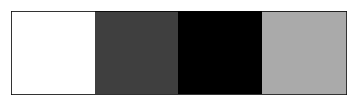

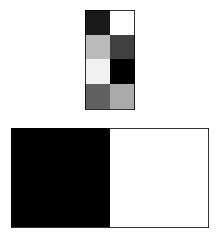

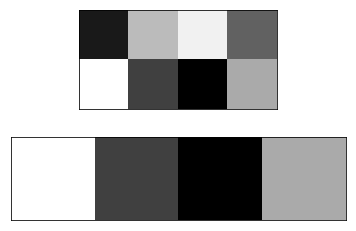

In [16]:
fig = plt.imshow([t],
                 cmap="gray",
                 interpolation='none',
                 vmax=np.max(t), vmin=np.min(t))
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
for l in layers:
    l.reset_error()
    l.plot()
    print()

## Validating

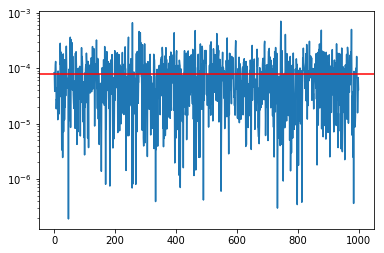

In [17]:
validate_errors = []
for i in range(0, 1000):
    target = sample()
    output = forward(layers, target, use_bias )
    err = error(target, output) 
    validate_errors += [err]

plt.plot(range(0, len(validate_errors)), validate_errors)
plt.axhline(y=np.mean(validate_errors), color="red")
plt.yscale('log')